In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [20]:
!pip install tensorflow

### Load and data analysis

First things first, load the training dataset. Although this is an image recognition task, the data comes in a csv format rather than a directory of PNGs/JPGs. The easiest way to load this data is to use pandas. We'll do this and have a look at the first row.

In [3]:
data = pd.read_csv('../input/digit-recognizer/train.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


So we can see that each row of data represents an image. Each image is made up 784 pixels (which is a 28x28 image). Each pixel is represented in the columns with a prefix of "pixel". These columns contain a number between 0 and 255 where 0 represents a white pixel, 255 a black pixel and the other numbers represent shades of grey.

We also have a column called "label" that represents the number in the image (the images class). This number will be anything between 0 and 9.

To test the model as it trains I will split the dataset into a training and validation dataset. Then I'll remove the labels from the datasets and put them into their own dataframes. I want to make a lot of the images available for training so taking some influence from other notebooks in this competition I'm going to go for a 90%-10% split.

In [4]:
train_data = data.head(37800)
val_data = data.tail(4200)

train_labels = train_data.pop('label')
val_labels = val_data.pop('label')

In [13]:
train_labels

0        1
1        0
2        1
3        4
4        0
        ..
37795    2
37796    2
37797    4
37798    7
37799    6
Name: label, Length: 37800, dtype: int64

using Tensorflow to train an image classifier model. Tensorflow has it's own api for creating a data pipeline which makes it easier to feed the data into a Tensorflow model. To use this api the data needs to be loaded into a Tensorflow data object. 

In [5]:
tf_train_data = tf.data.Dataset.from_tensor_slices((train_data.values, train_labels.values))
tf_val_data = tf.data.Dataset.from_tensor_slices((val_data.values, val_labels.values))

print(tf_train_data)
print(tf_val_data)

<TensorSliceDataset shapes: ((784,), ()), types: (tf.int64, tf.int64)>
<TensorSliceDataset shapes: ((784,), ()), types: (tf.int64, tf.int64)>


Before going on to form the data pipeline, I'll have a look at some of the images in the dataset and visualise them with their labels. As pixels for the images have been flattened into a 2D array, I have used a reshape function to put the images into a 28x28 shape that is more human friendly.

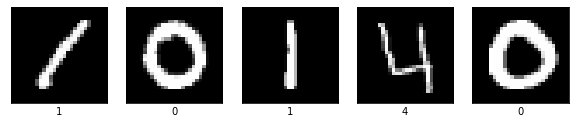

In [6]:
plt.figure(figsize=(10,10))
i = 0

for image, label in tf_train_data.take(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image.numpy().reshape((28, 28)), cmap='gray')
    plt.xlabel(label.numpy())

    i = i + 1

### Data pipeline

Now that the data is loaded and a quick piece of analysis has been done I am ready to form the pipeline that will feed the images into the model. The first step is to perform some small transformations to the images. I'll do the following to each image:

1. **Reshape:** The images are currently formatted as a flat list of pixels. CNNs need the data to be reshaped into a 3D matrix which in this case is a 28x28 matrix. I also need to specify the channels. As these images are greyscale I only need the one. The shape of the data then is (28, 28, 1).
2. **Scale:** Models seem to perform better when numeric features are put onto a 0-1 scale. As all the features are numeric and on a 0-255 scale it is easy to put the data onto this scale by simply dividing the features by 255.

In [7]:
def preprocess_image(image, label):
    image = tf.reshape(image, [28, 28, 1])
    image = tf.cast(image, tf.float32) / 255.
    
    return image, label

tf_train_data = tf_train_data.map(
    preprocess_image, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

tf_val_data = tf_val_data.map(
    preprocess_image, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

print(tf_train_data)
print(tf_val_data)

<ParallelMapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>
<ParallelMapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>


Now the data is preprocessed there are few configurations that can be made to the pipeline. Here's a list of those configurations:

1. **Shuffle:** To make sure the model doesn't pick up anything from the order of the rows in the dataset the top 100 rows of data will be shuffled per training step. 
2. **Batch:** This is quite a large dataset in terms of both rows and columns. To ensure the processor doesn't get overloaded the data will be fed in 32 images at a time.
3. **Prefetch:** The speed up the training the pipeline can be set to fetch the next batch of data while the current batch of data is in training. When the current step ends there is no time wasted loading the next batch as it is ready to go.

In [8]:
def pipeline(tf_data):
    tf_data = tf_data.shuffle(100)
    tf_data = tf_data.batch(32)
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    
    return tf_data

tf_train_data = pipeline(tf_train_data)
tf_val_data = pipeline(tf_val_data)

print(tf_train_data)
print(tf_val_data)

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


### Train model

The data is now ready to be fed into a model. I've chosen to use a CNN here and will be using an architecture based on the LeNet-5 architecture. I won't go into how CNNs work or why they are good for image classification tasks in this notebook. If you would like to learn more about them though I learnt about them on this [course](https://www.coursera.org/learn/convolutional-neural-networks?specialization=deep-learning) by Andrew Ng and I can't recommend it highly enough.

Although I learnt about the LeNet-5 CNN architecture on the course and not by reading the paper it only seems right to quote the paper that LeNet-5 comes from:
*"LeCun et al., 1998, Gradient-based learning applied to document recognition"*

So without further ado I'll use Tensorflow to define the model. As you will see the model is much the same as the LeNet-5 model except for a few changes:

1. All average pooling layers have been replaced with max pooling layers
2. The input shape is slightly smaller than the 32x32 shape in the paper. The first convolutional layer uses "same" padding to ensure the data is in the same shape as it is in the paper by the time it hits the first pooling layer.

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    
    tf.keras.layers.Dense(10, activation='softmax'),
])

Now I'll compile the model and get a print out describing it.

In [10]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimiser, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

Tensorflow has a piece of functionality called callbacks that enable us to monitor the models metrcis during training and take some action as a result. Using this functionality I will implement the following:

1. **Learning Rate Decay:** If the models loss does not reduce for 2 consecutive epochs, reduce the learning rate. This should stop the model stepping over the optimum too many times.
2. **Early Stopping:** If the models loss does not reduce for 5 consecutive epochs then it's clear the model is not learning anything anymore. Save some computation and stop training.

Note: the verbose parameter simply states whether a message should be printed in the console (1) or not (0) when a callback is made.

In [11]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

With the model compiled and the data sitting ready in the pipeline it is time to train the model. The validation dataset has been included here so that the model validates its accuracy after each step by making predictions against the validation dataset.

Note: Each epoch takes around 22 seconds to complete so this may take a few minutes to run depending on how many epochs this is run for.

In [14]:
train_log = model.fit(
    tf_train_data,
    validation_data=tf_val_data,
    epochs=10,
    callbacks=callbacks
)

Train for 1182 steps, validate for 132 steps
Epoch 1/10
1182/1182 [==============================] - 17s 14ms/step - loss: 0.0133 - accuracy: 0.9952 - val_loss: 0.0880 - val_accuracy: 0.9790
Epoch 2/10
1182/1182 [==============================] - 17s 14ms/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.0646 - val_accuracy: 0.9840
Epoch 3/10
1182/1182 [==============================] - 17s 14ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.0816 - val_accuracy: 0.9819
Epoch 4/10
1182/1182 [==============================] - 17s 14ms/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.0751 - val_accuracy: 0.9838
Epoch 5/10
1180/1182 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9967
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1182/1182 [==============================] - 17s 14ms/step - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.0538 - val_accuracy: 0.9857
Epoch 6/10
1182/1182 [==============================] - 1

With the model trained I'll plot the accuracy achieved per epoch per dataset on a chart so that training progress is clearer.

Training accuracy: 1.000000
Validation accuracy: 0.991190


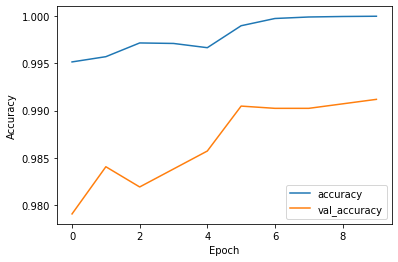

In [15]:
plt.plot(train_log.history['accuracy'], label='accuracy')
plt.plot(train_log.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

print('Training accuracy: %f' % train_log.history['accuracy'][-1])
print('Validation accuracy: %f' % train_log.history['val_accuracy'][-1])

### Inference

The final step is to use this trained model to classify the images in the test dataset. The first step is to load the training dataset and put it into the Tensorflow data format.

In [16]:
test_data = pd.read_csv('../input/digit-recognizer/test.csv')
tf_test_data = tf.data.Dataset.from_tensor_slices(([test_data.to_numpy().reshape(len(test_data), 28, 28, 1)]))

Then use the model to classify each image. The model will not just output one class but will instead output a probability for each possible class. Numpys argmax is thus used to find the class with the highest probability and this class is used for the image.

In [17]:
predictions = model.predict(tf_test_data)
predictions = np.argmax(predictions, axis=1)

To see if the model is performing as expected I will check visualisations of the first fifteen images against the classifications produced by the model.

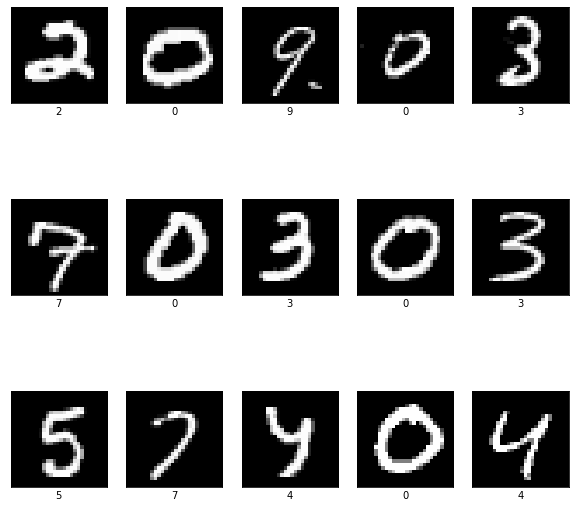

In [18]:
plt.figure(figsize=(10,10))

for i, row in test_data.head(15).iterrows():
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(row.values.reshape((28, 28)), cmap='gray')
    plt.xlabel(predictions[i])

While it is unfeasible to eyeball all 28000 test images and predicted classes, checking the first fifteen and seeing 98% accuracy on the validation dataset gives me some confidence that the model is performing well. The last thing to do then is to put the classifications into a submission dataframe and write it to a csv file.

In [19]:
predictions_df = pd.DataFrame(data={'Label': predictions}, index=pd.RangeIndex(start=1, stop=28001))
predictions_df.index = predictions_df.index.rename('ImageId')

# predictions_df.to_csv('submission_file.csv')